<a href="https://colab.research.google.com/github/ykitaguchi77/YOLACT_Mobius/blob/main/YOLOv%EF%BC%98_dataset_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mobius_dataset --> YOLOv8 instance segmentation training**

2024研究室配属（鈴木くん、北口くん）

```
To do：

Mobiusのマスク画像をYOLOv8形式のテキストファイルに

マスク画像がない画像を除外

YOLOv8用のフォルダ構成に
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**COCO_json形式への変換**

In [31]:
import cv2
import numpy as np
import json
from skimage import measure
import os
from google.colab import drive
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

# 画像から特定の色のマスクを作成する
def create_mask(image, color):
    return np.all(image == color, axis=-1)

# マスクを適用して画像を変換する
def apply_mask(image, mask):
    return np.where(mask, 255, 0)

# 画像から輪郭を抽出し、点のリストを生成する
def extract_contours(img, _num_points):
    contours = measure.find_contours(img, 0.5)
    points_list = []

    for contour in contours:
        contour_length = len(contour)

        if contour_length > _num_points:
            step = contour_length // _num_points
            selected_points = [contour[i * step] for i in range(_num_points)]
        else:
            selected_points = contour

        points = [[float(point[1]), float(point[0])] for point in selected_points]
        points_list.append(points)

    return points_list

# 点のリストからJSONファイルを作成する
def create_json(points_list_blue, points_list_blue_green, points_list_all_colors, json_name, img_path, img_data, img_height, img_width):
    data = {
        "version": "5.4.1",
        "flags": {},
        "shapes": [],
        "imagePath": img_path,
        "imageData": img_data,
        "imageHeight": img_height,
        "imageWidth": img_width
    }

    # 点のデータをJSON構造に追加
    data["shapes"].append({
        "label": "eyelid",
        "points": points_list_all_colors,
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None
    })

    data["shapes"].append({
        "label": "iris",
        "points": points_list_blue_green,
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None
    })

    data["shapes"].append({
        "label": "pupil",
        "points": points_list_blue,
        "group_id": None,
        "description": "",
        "shape_type": "polygon",
        "flags": {},
        "mask": None
    })

    with open(json_name, 'w') as fw:
        json.dump(data, fw, indent=2)

# 画像からマスクを作成し、輪郭を抽出してJSONファイルに保存する
def process_single_image(mask_file, json_name):
    img = cv2.imread(mask_file, cv2.IMREAD_COLOR)
    img_height, img_width = img.shape[:2]

    mask_blue = create_mask(img, [255, 0, 0])
    mask_green = create_mask(img, [0, 255, 0])
    mask_red = create_mask(img, [0, 0, 255])

    mask_blue_green = np.logical_or(mask_blue, mask_green)
    mask_all_colors = np.logical_or(mask_blue_green, mask_red)

    img_blue = apply_mask(img, mask_blue)
    img_blue_green = apply_mask(img, mask_blue_green)
    img_all_colors = apply_mask(img, mask_all_colors)

    points_list_blue = extract_contours(img_blue, num_points)
    points_list_blue_green = extract_contours(img_blue_green, num_points)
    points_list_all_colors = extract_contours(img_all_colors, num_points)

    create_json(points_list_blue, points_list_blue_green, points_list_all_colors, json_name, mask_file, "/9", img_height, img_width)

# ディレクトリ内の全画像に対して上記の処理をまとめて行う
def process_images(mask_dir, output_json_dir, num_images=10):
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"The directory {mask_dir} does not exist.")

    if not os.path.exists(output_json_dir):
        user_input = input(f"The directory {output_json_dir} does not exist. Do you want to create it? (y/n): ")
        if user_input.lower() == 'y':
            os.makedirs(output_json_dir)
            print(f"Created directory {output_json_dir}")
        else:
            print("Directory not created. Exiting the process.")
            return

    total_images = sum([len(files) for r, d, files in os.walk(mask_dir) if files])

    with tqdm(total=min(total_images, num_images)) as pbar:
        for folder in os.listdir(mask_dir):
            folder_path = os.path.join(mask_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            output_folder = os.path.join(output_json_dir, folder)
            os.makedirs(output_folder, exist_ok=True)

            for filename in os.listdir(folder_path):
                if filename.endswith(".png"):
                    mask_file = os.path.join(folder_path, filename)
                    json_name = os.path.join(output_folder, filename.replace(".png", ".json"))

                    process_single_image(mask_file, json_name)

                    pbar.update(1)
                    if pbar.n >= num_images:
                        return



In [32]:
#マスクされた画像のパスを指定してください。
mask_file = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/masks/1/1_1i_Ll_1.png"
json_name = "/content/output.json"

#輪郭点の個数を指定してください。
num_points = 24

process_single_image(mask_file, json_name)

# 元画像と輪郭の比較
matplotlib.rcParams['axes.unicode_minus'] = False
with open('/content/output.json') as f:
    data = json.load(f)

points_eyelid = []
points_iris = []
points_pupil = []
for shape in data['shapes']:
    if shape['label'] == 'eyelid':
        points_eyelid += shape['points'][0]
    elif shape['label'] == 'iris':
        points_iris += shape['points'][0]
    elif shape['label'] == 'pupil':
        points_pupil += shape['points'][0]


x_eyelid = [point[0] for point in points_eyelid]
y_eyelid = [point[1] for point in points_eyelid]

x_iris = [point[0] for point in points_iris]
y_iris = [point[1] for point in points_iris]

x_pupil = [point[0] for point in points_pupil]
y_pupil = [point[1] for point in points_pupil]

# 元の画像を読み込む
img_path = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/images/1/1_1i_Ll_1.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# 図の左隣に元の画像を表示する
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("original")

# 図の右隣に散布図を表示する
plt.subplot(1, 2, 2)
plt.scatter(x_eyelid, y_eyelid, label='eyelid')
plt.scatter(x_iris, y_iris, label='iris')
plt.scatter(x_pupil, y_pupil, label='pupil')
plt.title("contour")#輪郭

# 縦横の縮尺を同じにする
plt.axis('equal')

# 縦軸を降順にする
plt.gca().invert_yaxis()

# 凡例を表示する
plt.legend()

# 図を表示する
plt.show()



<ipython-input-32-e6a460a0f4bc>:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


In [33]:

# 基本ディレクトリと出力ディレクトリの設定
mask_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/masks"
output_json_dir = "/content/output_json"

In [34]:
# 最初は10枚の画像でテスト
process_images(mask_dir, output_json_dir, num_images=10)

# 問題がなければ全画像に適用
# process_images(base_dir, output_dir, num_images=float('inf'))

The directory /content/output_json does not exist. Do you want to create it? (y/n): y
Created directory /content/output_json


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


In [35]:
import os
import json
from tqdm import tqdm

def process_all_json_files(json_dir, num_images=10):
    # JSONファイルの総数を取得
    total_files = sum([len(files) for r, d, files in os.walk(json_dir) if files])

    # tqdmを使って進捗バーを初期化
    with tqdm(total=min(total_files, num_images)) as pbar:
        for root, dirs, files in os.walk(json_dir):
            for file in files:
                if file.endswith(".json"):
                    json_file_path = os.path.join(root, file)

                    # JSONファイルを読み込み
                    with open(json_file_path, 'r') as json_file:
                        data = json.load(json_file)

                    # imagePathの値をファイル名のみに更新
                    data["imagePath"] = os.path.basename(data["imagePath"])

                    # JSONファイルに変更を保存
                    with open(json_file_path, 'w') as json_file:
                        json.dump(data, json_file, indent=4)

                    pbar.update(1)  # 進捗バーを更新
                    if pbar.n >= num_images:
                        return  # 指定された数のファイルを処理したら終了

# JSONディレクトリのパス
json_dir = "/content/output_json"

# 最初は10個のファイルでテスト
process_all_json_files(json_dir, num_images=10)

# 問題がなければ、全ファイルに適用
#process_all_json_files(json_dir, num_images=float('inf'))


100%|██████████| 10/10 [00:00<00:00, 1339.99it/s]


In [ ]:
# # prompt: jsonフォルダ内のフォルダに入っている全てのファイルをバラバラの状態で一つ一つ、/content/drive/MyDrive/AI_laboratory_course/MOBIUS/json_concatにコピーを作成してください

# import os
# import shutil

# source_dir = "/content/output_json"
# target_dir = "/content/concat_json"

# # Create the directory if it doesn't exist
# if not os.path.exists(target_dir):
#     os.makedirs(target_dir)
#     print(f"Directory '{target_dir}' was created.")


# for folder in os.listdir(source_dir):
#     folder_path = os.path.join(source_dir, folder)
#     print(folder_path)
#     if os.path.isdir(folder_path):
#         for file in os.listdir(folder_path):
#             file_path = os.path.join(folder_path, file)
#             print(file_path)
#             shutil.copy(file_path, target_dir)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install labelme2coco
# import labelme2coco

# # LabelMeアノテーションと画像ファイルが含まれるディレクトリを設定
# labelme_folder = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/concat_json"

# # エクスポートするディレクトリを設定
# export_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/coco_format"

# # トレーニングデータの分割率を設定
# train_split_rate = 0.85

# # LabelMeアノテーションをCOCO形式に変換
# labelme2coco.convert(labelme_folder, export_dir, train_split_rate)

## ネストを減らすコード (要修正)

In [16]:
import json
import os
from tqdm import tqdm

def convert_points_format(json_file_path):
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for shape in data['shapes']:
        # ネストを1レベル減らします
        shape['points'] = [point[0] for point in shape['points']]

    with open(json_file_path, 'w') as file:
        json.dump(data, file, indent=4)

# JSONファイルが保存されているディレクトリへのパス
json_dir = "/content/concat_json"

# JSONファイルの総数を取得
total_files = sum([len(files) for r, d, files in os.walk(json_dir) if files])

# ディレクトリ内の全てのJSONファイルに対して上記の関数を適用（tqdmを使用）
with tqdm(total=total_files, desc="Converting JSON files") as pbar:
    for root, dirs, files in os.walk(json_dir):
        for file in files:
            if file.endswith(".json"):
                json_file_path = os.path.join(root, file)
                convert_points_format(json_file_path)
                pbar.update(1)

Converting JSON files: 100%|██████████| 10/10 [00:00<00:00, 1257.32it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install labelme2coco
import labelme2coco

# LabelMeアノテーションと画像ファイルが含まれるディレクトリを設定
labelme_folder = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/ex_json"

# エクスポートするディレクトリを設定
export_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/coco_format"

# トレーニングデータの分割率を設定
train_split_rate = 0.85

# LabelMeアノテーションをCOCO形式に変換
labelme2coco.convert(labelme_folder, export_dir, train_split_rate)

In [ ]:
# LabelMeアノテーションと画像ファイルが含まれるディレクトリを設定
labelme_folder = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/concat_json"

# エクスポートするディレクトリを設定
export_dir = "/content/drive/MyDrive/AI_laboratory_course/MOBIUS/coco_format"

# トレーニングデータの分割率を設定
train_split_rate = 0.85

# フォルダ内のファイルリストを取得
file_list = os.listdir(labelme_folder)

# 進捗バーを表示してLabelMeアノテーションをCOCO形式に変換
for file_name in tqdm(file_list, desc="Converting to COCO"):
    if file_name.endswith('.json'):
        json_file_path = os.path.join(labelme_folder, file_name)
        labelme2coco.convert(json_file_path, export_dir, train_split_rate)

print("Conversion complete.")

##**YOLOv8形式のアノーテーションへの変換**

In [47]:
import cv2
import numpy as np
from skimage import measure
import os
from google.colab import drive
import matplotlib
from matplotlib import pyplot as plt

def create_mask(image, color):
    return np.all(image == color, axis=-1)

def apply_mask(image, mask):
    return np.where(mask, 255, 0)

def extract_contours(img, _num_points):
    contours = measure.find_contours(img, 0.5)
    points_list = []

    for contour in contours:
        contour_length = len(contour)

        if contour_length > _num_points:
            step = contour_length // _num_points
            selected_points = [contour[i * step] for i in range(_num_points)]
        else:
            selected_points = contour

        points = [[float(point[1]), float(point[0])] for point in selected_points]
        points_list.append(points)

    return points_list

def normalize_coordinates(points_list, img_width, img_height):
    normalized_points_list = []
    for points in points_list:
        normalized_points = [[x / img_width, y / img_height] for x, y in points]
        normalized_points_list.append(normalized_points)
    return normalized_points_list

def write_yolov8_annotation(points_list, class_index, img_width, img_height, file):
    for points in points_list:
        normalized_points = normalize_coordinates([points], img_width, img_height)[0]
        line = f"{class_index} " + " ".join(f"{x} {y}" for x, y in normalized_points) + "\n"
        file.write(line)

def create_yolov8_text(mask_file, yolov8_annotation_file, num_points):
    img = cv2.imread(mask_file, cv2.IMREAD_COLOR)
    img_height, img_width = img.shape[:2]

    mask_blue = create_mask(img, [255, 0, 0])
    mask_green = create_mask(img, [0, 255, 0])
    mask_red = create_mask(img, [0, 0, 255])

    mask_blue_green = np.logical_or(mask_blue, mask_green)
    mask_all_colors = np.logical_or(mask_blue_green, mask_red)

    img_blue = apply_mask(img, mask_blue)
    img_blue_green = apply_mask(img, mask_blue_green)
    img_all_colors = apply_mask(img, mask_all_colors)

    points_list_blue = extract_contours(img_blue, num_points)
    points_list_blue_green = extract_contours(img_blue_green, num_points)
    points_list_all_colors = extract_contours(img_all_colors, num_points)

    with open(yolov8_annotation_file, 'w') as file:
        # クラスインデックス 0: 瞼
        write_yolov8_annotation(points_list_blue, 0, img_width, img_height, file)
        # クラスインデックス 1: 虹彩
        write_yolov8_annotation(points_list_blue_green, 1, img_width, img_height, file)
        # クラスインデックス 2: 瞳
        write_yolov8_annotation(points_list_all_colors, 2, img_width, img_height, file)

mask_file = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/masks/1/1_1i_Ll_2.png"
yolov8_annotation_file = "/content/yolov8_annotation.txt"
num_points = 24

create_yolov8_text(mask_file, yolov8_annotation_file, num_points)


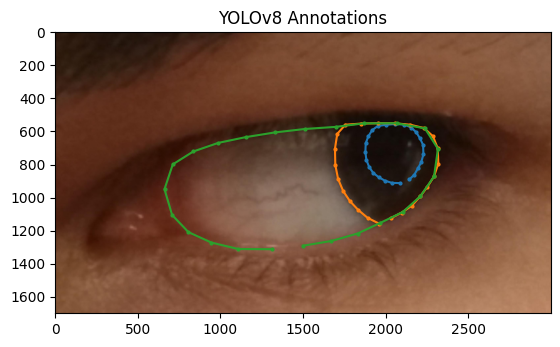

In [48]:
# YOLOv8フォーマットの確認（imgへの重ね合わせ）
import matplotlib.pyplot as plt
import cv2
%matplotlib inline


def read_yolov8_annotation(file_path, img_width, img_height):
    annotations = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_index = int(parts[0])
            points = [(float(parts[i]), float(parts[i + 1])) for i in range(1, len(parts), 2)]
            # 正規化解除
            points = [(x * img_width, y * img_height) for x, y in points]
            annotations.append((class_index, points))
    return annotations

def plot_annotations(img, annotations):
    plt.imshow(img)
    for class_index, points in annotations:
        xs, ys = zip(*points)
        plt.plot(xs, ys, marker='o', markersize=2, linestyle='-')

    plt.title("YOLOv8 Annotations")
    plt.show()

# YOLOv8 アノーテーションファイルのパス
yolov8_annotation_file = "/content/yolov8_annotation.txt"

# 元の画像のパス
img_path = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/images/1/1_1i_Ll_2.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_height, img_width = img.shape[:2]

# アノーテーションの読み込みとプロット
annotations = read_yolov8_annotation(yolov8_annotation_file, img_width, img_height)
plot_annotations(img, annotations)


In [25]:
import os
import glob
import shutil

images_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/images/1"
masks_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/masks/1"
output_text_dir = "/content/yolo8_annotation/"
num_points = 24

if os.path.exists(output_text_dir):
    shutil.rmtree(output_text_dir)
os.makedirs(output_text_dir)

filename_list = [os.path.splitext(f)[0] for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]

for img in glob.glob(f"{images_dir}/*")[0:5]:
    if os.path.splitext(os.path.basename(img))[0] in filename_list:
        print(f"processing... {os.path.splitext(os.path.basename(img))[0]}")
        txt_name = f"{output_text_dir}/{os.path.splitext(os.path.basename(img))[0]}.txt"
        img = f"{masks_dir}/{os.path.splitext(os.path.basename(img))[0]}.png"
        create_yolov8_text(img, txt_name, num_points)
    else:
        print("false")

processing... 1_1i_Ll_2
processing... 1_1i_Ll_1
processing... 1_1i_Lr_1
processing... 1_1i_Ls_1
processing... 1_1i_Lr_2


In [ ]:
# 対応するマスク画像を使用してYOLOv8用のアノテーションテキストファイルを生成します。
# images_dirの各サブディレクトリ(/1, /2など)に対して、同じ処理を適用します。
# 同様に、masks_dirのサブディレクトリからマスク画像を取得し、
# 出力テキストファイルをoutput_text_dirの同じサブディレクトリ構造に保存します。

import os
import glob
import shutil

images_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/images"
masks_dir = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/Sample_Mobius_dataset/masks"
output_text_dir = "/content/yolo8_annotation/"
num_points = 24

# 出力ディレクトリの初期化
if os.path.exists(output_text_dir):
    shutil.rmtree(output_text_dir)
os.makedirs(output_text_dir)

# images_dirのサブディレクトリを走査
for subdir in os.listdir(images_dir):
    images_subdir = os.path.join(images_dir, subdir)
    masks_subdir = os.path.join(masks_dir, subdir)
    output_subdir = os.path.join(output_text_dir, subdir)

    if os.path.isdir(images_subdir) and os.path.isdir(masks_subdir):
        os.makedirs(output_subdir, exist_ok=True)

        # ファイル名リストを取得
        filename_list = [os.path.splitext(f)[0] for f in os.listdir(images_subdir) if os.path.isfile(os.path.join(images_subdir, f))]

        #for img_path in glob.glob(f"{images_subdir}/*"):
        for img_path in glob.glob(f"{images_subdir}/*")[0:5]:
            base_name = os.path.splitext(os.path.basename(img_path))[0]

            if base_name in filename_list:
                print(f"processing... {base_name}")
                txt_name = os.path.join(output_subdir, f"{base_name}.txt")
                mask_img_path = os.path.join(masks_subdir, f"{base_name}.png")
                create_yolov8_text(mask_img_path, txt_name, num_points)
            else:
                print("false")


In [ ]:
# #################
# # 北口くんの変換コード #
# #################
# from time import monotonic#多分いらない
# #本体は以下から
# from google.colab import drive
# drive.mount('/content/drive')
# #driveのマウント

# import os
# import json
# import numpy as np

# # jsonファイルの入っているフォルダのパスを指定
# folder_path = '/content/drive/MyDrive/json-20240205T053811Z-001/json/4'



# # フォルダ内の全ファイルにアクセス
# for filename in os.listdir(folder_path):
#     file_path = os.path.join(folder_path, filename)

#     # ファイルかどうかを確認
#     if os.path.isfile(file_path):
#         # ここでファイルに対する処理を行います
#         print(f'ファイル名: {filename}, ファイルパス: {file_path}')


#         with open(file_path,'r') as json_open:

#             json_load = json.load(json_open)
#             height = json_load['imageHeight']
#             width = json_load['imageWidth']
#             wh = np.array([width,height]) #割るための分母配列
#             # テキストファイルを作成し、テキストを書き込む
#             txtfile_name = f'{filename[:-5]}.txt'   #拡張子(.json)を削除
#             txtfile_path = os.path.join('/content/drive/MyDrive/textfile_for_v8/4', txtfile_name)  # ファイルの名前と保存先のパスを指定

#             for i in range(3):#eyelid,irys,pupilの三回分
#                 points = [i for sublist in json_load['shapes'][i]['points'] for i in sublist]
#                 pointsnp = np.array(points)
#                 res = pointsnp/wh
#                 monores = [element for row in res for element in row]#次元下げ

#                 line = ' '.join(map(str, monores))


#                 text_to_write = f'{i} {line}\n'  #書く内容
#                 with open(txtfile_path, 'a') as file:

#                     file.write(text_to_write)



#                 print(f'{file_path} ファイルを作成しました。{points} {wh}')#不要

#**YOLOv8のtrain (鈴木くん)**

・ badが含まれている画像およびannotationを削除する

・ imagesのpngとannotationのテキストとを同じフォルダにして、trainとvalに分ける

In [3]:
from google.colab import drive
drive.mount('/content/drive')
#driveのマウント

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
%cd /content
!git clone https://github.com/ultralytics/ultralytics
%cd ultralytics
#yolov8

/content
fatal: destination path 'ultralytics' already exists and is not an empty directory.
/content/ultralytics


##簡単に確認

In [ ]:
#本体
from ultralytics import YOLO
model = YOLO("yolov8x.pt")

results = model("https://ultralytics.com/images/bus.jpg",save=True)
#Results saved to /content/ultralytics/runs/detect/predictの下に保存される

In [ ]:
model = YOLO("yolov8n-seg.pt")
results = model('bus.jpg',save=True,task='segment')#/content/ultralytics/bus.jpgを利用
#Results saved to /content/ultralytics/runs/segment/predictの下に保存される

##Trainig

In [ ]:
#Badが含まれているファイルを削除
import os
import shutil

directory_list = ["/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8/images/train",
                  "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8/images/val"]

# ディレクトリ内のすべてのファイルとフォルダをチェック
for directory in directory_list:
    for item in os.listdir(directory):
        # "bad"という文字列が含まれているか確認
        if "bad" in item:
            path_to_remove = os.path.join(directory, item)

            # ファイルまたはフォルダを削除
            if os.path.isfile(path_to_remove):
                os.remove(path_to_remove)
            elif os.path.isdir(path_to_remove):
                shutil.rmtree(path_to_remove)
            print(f"Removed: {path_to_remove}")

In [55]:
# YAMLファイルの作成

%%writefile /content/eyesegmentation.yaml
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: /content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8  # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')
test: images/val # test images (optional)

# Classes
names:
  0: eyelid
  1: iris
  2: pupil

# Download script/URL (optional)
download: https://ultralytics.com/assets/coco128-seg.zip

Overwriting /content/eyesegmentation.yaml


In [52]:
# #本体
# import shutil

# # コピー元ファイルのパス
# source_file_path = '/content/drive/MyDrive/eyeditect-1.yaml'

# # コピー先フォルダのパス
# destination_folder = '/content/ultralytics/ultralytics/cfg/datasets'

# # shutilモジュールのcopy関数を使用してファイルをコピー
# shutil.copy(source_file_path, destination_folder)

In [56]:
from ultralytics import YOLO
#本体
#nc = 3に変更
# Load a model
model = YOLO('yolov8n-seg.yaml').load('yolov8n-seg.pt')  # build from YAML and transfer weights

Transferred 417/417 items from pretrained weights


In [57]:
result =  model.train(data='/content/eyesegmentation.yaml', epochs=30, imgsz=640)

Ultralytics YOLOv8.1.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=/content/eyesegmentation.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

train: Scanning /content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8/labels/train... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:46<00:00,  7.27it/s]


train: New cache created: /content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8/labels/val... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:14<00:00,  6.28it/s]

val: New cache created: /content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8/labels/val.cache


Plotting labels to /content/ultralytics/runs/segment/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/ultralytics/runs/segment/train5
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      5.42G      1.466      4.113      2.908      1.592         36        640: 100%|██████████| 22/22 [00:09<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         88        264      0.977      0.159      0.548      0.385      0.961      0.151      0.479      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30      5.32G      1.106      2.339      1.335      1.309         17        640: 100%|██████████| 22/22 [00:05<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

                   all         88        264      0.957      0.564      0.637       0.46      0.929      0.542      0.599       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30      5.27G      1.121      2.142      1.197      1.283         33        640: 100%|██████████| 22/22 [00:05<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         88        264      0.907      0.591      0.797      0.509      0.919      0.571      0.794      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30       5.4G       1.03      1.985      1.027      1.223         28        640: 100%|██████████| 22/22 [00:05<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         88        264      0.944      0.711      0.836      0.621      0.934      0.699       0.81      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      5.42G      1.035      2.004     0.9962      1.235         25        640: 100%|██████████| 22/22 [00:05<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         88        264      0.849        0.7      0.895      0.611      0.807      0.683      0.848      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      5.32G     0.9909      1.975     0.9434      1.208         31        640: 100%|██████████| 22/22 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         88        264      0.832      0.786      0.855      0.616      0.829      0.792      0.856      0.473



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      5.39G     0.9703      1.836     0.9013      1.188         26        640: 100%|██████████| 22/22 [00:05<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         88        264      0.865      0.852      0.878      0.644      0.847      0.852      0.874      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      5.24G      0.951      1.771     0.8528      1.168         19        640: 100%|██████████| 22/22 [00:05<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]

                   all         88        264      0.891      0.879      0.911      0.665      0.909      0.864      0.898      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30      5.27G     0.9597      1.853     0.8555      1.178         21        640: 100%|██████████| 22/22 [00:05<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         88        264      0.927      0.865      0.904      0.672      0.894       0.83      0.866      0.491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30      5.32G     0.9143      1.752     0.7984      1.175         25        640: 100%|██████████| 22/22 [00:05<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]

                   all         88        264      0.894      0.913      0.897      0.643      0.882      0.902      0.883      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30      5.34G     0.9451      1.798     0.8016      1.187         32        640: 100%|██████████| 22/22 [00:05<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

                   all         88        264      0.908      0.878      0.913      0.679      0.918      0.871      0.909      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30      5.38G     0.9105      1.672     0.7549      1.152         29        640: 100%|██████████| 22/22 [00:05<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         88        264      0.883      0.909      0.913      0.665      0.862      0.886      0.883      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30      5.25G     0.8769       1.68     0.7317      1.147         36        640: 100%|██████████| 22/22 [00:05<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         88        264      0.903      0.924      0.921       0.67      0.886      0.905      0.902      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      5.38G      0.879      1.694     0.7071      1.136         37        640: 100%|██████████| 22/22 [00:05<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]

                   all         88        264      0.884       0.83      0.868      0.642      0.867      0.815      0.831       0.48



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30      5.31G     0.8568      1.605     0.6751      1.111         39        640: 100%|██████████| 22/22 [00:05<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]

                   all         88        264      0.904      0.933      0.932       0.68      0.925      0.951      0.958      0.563



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30      5.28G     0.8465      1.566     0.6523      1.121         28        640: 100%|██████████| 22/22 [00:05<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         88        264      0.918      0.919      0.917      0.671      0.925      0.924      0.928      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30      5.33G      0.827      1.524     0.6433      1.096         34        640: 100%|██████████| 22/22 [00:05<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         88        264      0.908      0.917      0.912      0.678      0.905      0.917      0.916      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30      5.27G     0.8407      1.505     0.6256       1.11         23        640: 100%|██████████| 22/22 [00:05<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         88        264      0.863      0.881      0.875      0.657       0.87      0.887      0.885      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30      5.43G      0.819      1.516     0.6244        1.1         36        640: 100%|██████████| 22/22 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]

                   all         88        264      0.914      0.902      0.914      0.696       0.92      0.905      0.926       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30      5.39G     0.8044      1.533      0.599      1.089         24        640: 100%|██████████| 22/22 [00:05<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

                   all         88        264      0.938      0.943      0.948      0.708      0.934      0.939      0.944      0.565


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30      5.45G     0.8188      1.464     0.7228      1.131         12        640: 100%|██████████| 22/22 [00:09<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         88        264      0.949      0.942      0.958      0.705      0.945      0.939       0.95      0.567



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30      5.07G     0.7638      1.353     0.6298      1.114         12        640: 100%|██████████| 22/22 [00:05<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         88        264      0.936       0.95      0.936      0.688      0.925      0.944      0.936      0.555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30      5.07G     0.7617      1.381      0.608      1.089         12        640: 100%|██████████| 22/22 [00:04<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

                   all         88        264      0.914      0.913      0.934      0.696      0.908      0.911      0.933      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30      5.07G     0.7451      1.317     0.6005      1.089         12        640: 100%|██████████| 22/22 [00:04<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         88        264      0.938       0.89      0.935      0.702      0.909      0.919      0.937      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30      5.07G     0.7271      1.299     0.5853      1.099         12        640: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]

                   all         88        264      0.932      0.943      0.953      0.698       0.94      0.947      0.958       0.57



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30      5.07G     0.7356      1.322     0.5615       1.08         12        640: 100%|██████████| 22/22 [00:04<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         88        264      0.905      0.931      0.927      0.694      0.917      0.917      0.927      0.559



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30      5.07G     0.7031      1.249     0.5406      1.063         12        640: 100%|██████████| 22/22 [00:04<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]

                   all         88        264      0.932      0.936       0.94      0.717      0.936      0.939      0.947      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30      5.07G     0.7077       1.27     0.5298      1.064         12        640: 100%|██████████| 22/22 [00:04<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]

                   all         88        264      0.925      0.909      0.913      0.705       0.93      0.913      0.924      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30      5.07G     0.6772      1.202     0.5181      1.053         12        640: 100%|██████████| 22/22 [00:04<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

                   all         88        264      0.964      0.924      0.946      0.709      0.952      0.952      0.954      0.585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30      5.05G     0.6646      1.176     0.5043      1.036         12        640: 100%|██████████| 22/22 [00:04<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         88        264      0.926      0.902      0.914      0.702      0.926      0.909      0.917      0.563



30 epochs completed in 0.060 hours.
Optimizer stripped from /content/ultralytics/runs/segment/train5/weights/last.pt, 6.8MB
Optimizer stripped from /content/ultralytics/runs/segment/train5/weights/best.pt, 6.8MB

Validating /content/ultralytics/runs/segment/train5/weights/best.pt...
Ultralytics YOLOv8.1.20 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3258649 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


                   all         88        264      0.936      0.939      0.946      0.718      0.933      0.936      0.946      0.584
                eyelid         88         88      0.994          1      0.995      0.852      0.994          1      0.995      0.752
                  iris         88         88      0.994          1      0.995      0.882      0.983      0.989      0.985      0.592
                 pupil         88         88       0.82      0.818      0.847       0.42       0.82      0.818      0.856       0.41
Speed: 0.5ms preprocess, 2.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/ultralytics/runs/segment/train5


#**Inference trained model (鈴木くん)**

In [71]:
#本体
from ultralytics import YOLO
# コンフィグは学習時と同じコンフィグでよい
#model = YOLO("/Users/ryuka/workspace/Python/Image_AI/yolov8/ultralytics-main/ultralytics/cfg/models/v8/myyolov8.yaml")  # build a new model from scratch

# bestのモデルを使う,trainのウェイトのベストのパスを指定
model = YOLO("/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/sample_dataset_for_YOLOv8/last.pt")  # load a pretrained model (recommended for training)

#　画像のパスを指定
img_path = "/content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/testset(patient)/正常_小児_1.jpg"
results = model(img_path ,save=True, save_txt=True)  # predict on an image


image 1/1 /content/drive/MyDrive/Deep_learning/YOLACT_Mobius_ocular_dataset/testset(patient)/正常_小児_1.jpg: 640x640 1 eyelid, 1 iris, 1 pupil, 17.0ms
Speed: 1.5ms preprocess, 17.0ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/ultralytics/runs/segment/predict2
1 label saved to /content/ultralytics/runs/segment/predict2/labels


In [67]:
# オブジェクトの種類を調べる
for e in results[0].boxes.cls.cpu():
  print(e, model.names[int(e)])

tensor(1.) iris
tensor(0.) eyelid
tensor(2.) pupil


In [ ]:
results[0].boxes

In [ ]:
results[0].masks

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
img = cv2.imread(img_path)

cv2_imshow(img)

In [ ]:
for i, e in enumerate(results[0].masks.cpu().xy) :
  pos = e.reshape((-1,1,2)).astype(np.int32)
  cv2.polylines(img, [pos], isClosed=True, color= (255, 0, 32*i), thickness=2)
  # cv2.fillPoly(img, [pos], color= (255, 0, 32*i))

cv2_imshow(img)

In [63]:
result = results[0] #検出した結果をresultに格納
item=len(result.boxes) #検出したアイテムの数を出す
print(item)
box = result.boxes[0] #検出したアイテムのNo.0のBoxの情報

class_id = result.names[box.cls[0].item()]
cords = box.xyxy[0].tolist()
cords = [round(x) for x in cords]
conf = round(box.conf[0].item(), 2)

print("Object type:", class_id)
print("Coordinates:(四捨五入後の値)", cords)
print("Probability:", conf)

3
Object type: iris
Coordinates:(四捨五入後の値) [170, 215, 410, 419]
Probability: 0.93


In [ ]:
print(box)

In [60]:
result = results[0] #検出した結果をresultに格納
idem=len(result.boxes) #検出したアイテムの数を出す
print(idem)
box = result.boxes[1] #検出したアイテムのNo.0のBoxの情報

class_id = result.names[box.cls[0].item()]
cords = box.xyxy[0].tolist()
cords = [round(x) for x in cords]
conf = round(box.conf[0].item(), 2)

print("Object type:", class_id)
print("Coordinates:(四捨五入後の値)", cords)
print("Probability:", conf)

3
Object type: eyelid
Coordinates:(四捨五入後の値) [127, 210, 555, 436]
Probability: 0.93


In [61]:
#本体
result = results[0]
itemnums = len(result.boxes)
for i in range(itemnums):
    box = result.boxes[i]
    class_id = result.names[box.cls[0].item()]
    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    if class_id == 'eyelid':
        bunsi = cords[3]-cords[1]
    elif class_id == 'iris':
        bunbo = cords[2]-cords[0]
ans = 1.2*bunsi/bunbo
print('瞼裂径は{:.2f}'.format(ans),'㎝と予測されます！')

瞼裂径は1.13 ㎝と予測されます！


In [62]:
from PIL import Image

model =  YOLO('yolov8n-seg.pt')

# Run inference on 'bus.jpg'
results = model('/content/ultralytics/2019H-6_after_2.jpg')  # results list

# Show the results
for r in results:
    im_array = r.plot(masks = True)  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    im.save('results2.jpg')  # save image

FileNotFoundError: /content/ultralytics/2019H-6_after_2.jpg does not exist